.. _nb_portfolio_allocation:

## Portfolio Allocation



In this quick tutorial, the portfolio allocation problem shall be investigated. Of course, this is not financial advice in any way but should illustrate how multi-objective optimization can be applied to a quite interesting problem.

Let us start by loading some data for illustration purposes. Feel free to use your own.

In [1]:
import pandas as pd
import numpy as np
from pymoo.util.remote import Remote

file = Remote.get_instance().load("examples", "portfolio_allocation.csv", to=None)
df = pd.read_csv(file, parse_dates=True, index_col="date")

This tutorial is based on the Markowitz Mean-Variance Portfolio Theory and thus, we need to calculate the mean returns and covariances:

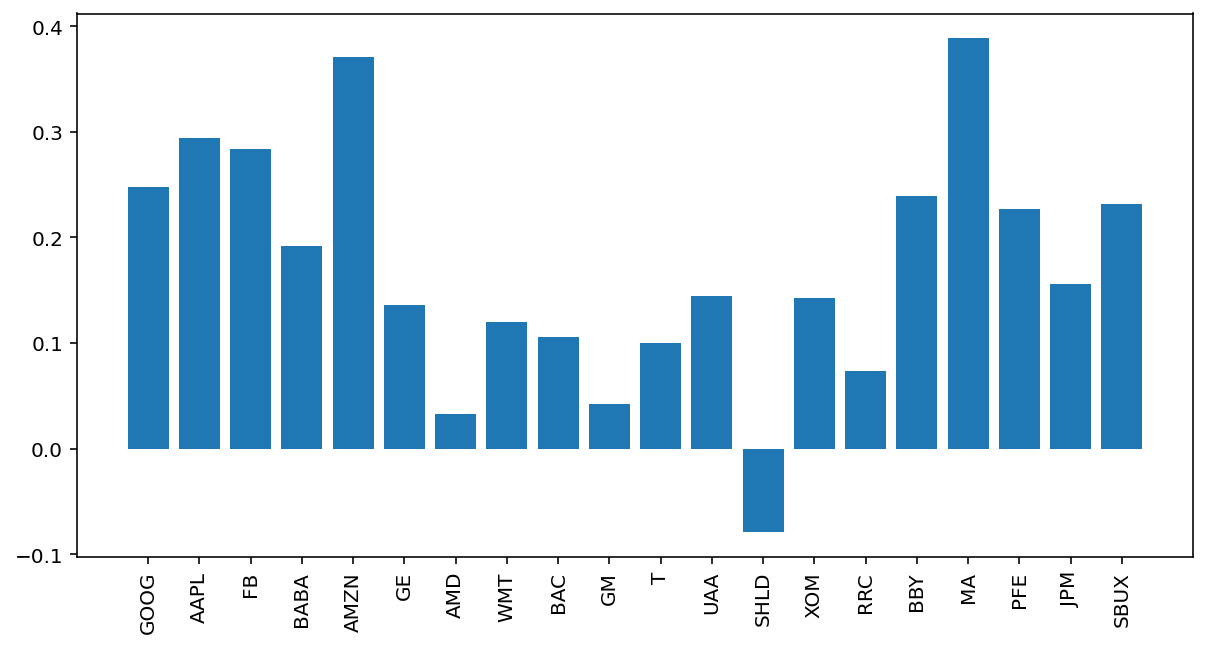

DONE


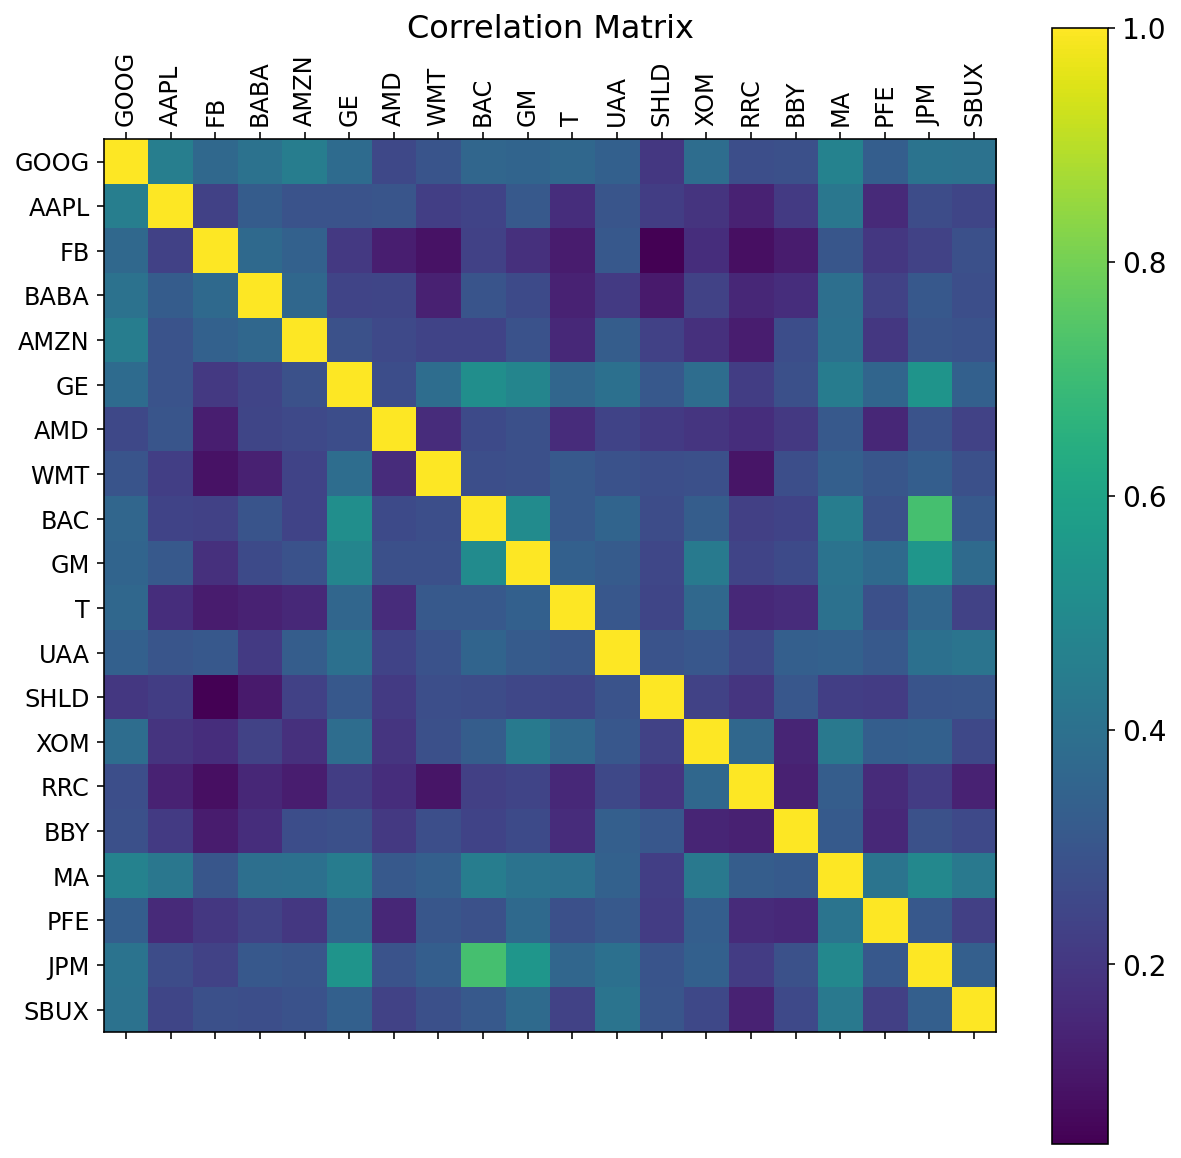

In [2]:
returns = df.pct_change().dropna(how="all")
mu = (1 + returns).prod() ** (252 / returns.count()) - 1
cov = returns.cov() * 252

mu, cov = mu.to_numpy(), cov.to_numpy()

labels = df.columns

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
k = np.arange(len(mu))
ax.bar(k, mu)
ax.set_xticks(k, labels, rotation = 90)
plt.show()


f = plt.figure(figsize=(10, 10))
plt.matshow(returns.corr(), fignum=f.number)
plt.xticks(k, labels, fontsize=12, rotation=90)
plt.yticks(k, labels, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
print("DONE")

Then let us define an optimization problem based on the theory mentioned above:

In [3]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblem(ElementwiseProblem):

    def __init__(self, mu, cov, risk_free_rate=0.02, **kwargs):
        super().__init__(n_var=len(df.columns), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk = np.sqrt(x.T @ self.cov @ x)
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = [exp_risk, -exp_return]
        out["sharpe"] = sharpe

Now, we should consider one more fact. The variable `x` defines what percentage we will invest in what product. Thus, it can not be more than 100\% in total. Moreover, an investment of a very small fraction does not really make sense. Thus we also incorporate each weight to be at least `1e-3` of the overall investment.

To ensure both, we can use a `Repair` operator (also see [here](../constraints/repair.ipynb)) which will directly be used by the optimization method.

In [4]:
from pymoo.core.repair import Repair

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis=1, keepdims=True)
    

Now let us see what solutions are found to be optimal:

In [5]:
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.optimize import minimize

problem = PortfolioProblem(mu, cov)

algorithm = SMSEMOA(repair=PortfolioRepair())

res = minimize(problem,
               algorithm,
               seed=1,
               verbose=False)

The algorithm has obtained a Pareto-optimal set trading off the mean return and volatility of the portfolio. 

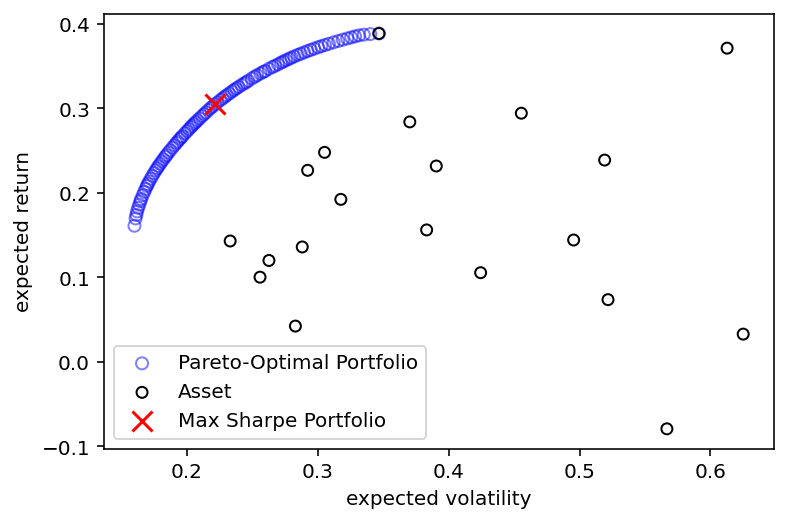

In [6]:
X, F, sharpe = res.opt.get("X", "F", "sharpe")
F = F * [1, -1]
max_sharpe = sharpe.argmax()

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
plt.legend()
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.show()

A common way for the decision making is looking at the sharpe ratio shown below:

In [7]:
import operator

allocation = {name: w for name, w in zip(df.columns, X[max_sharpe])}
allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)

print("Allocation With Best Sharpe")
for name, w in allocation:
    print(f"{name:<5} {w}")

Allocation With Best Sharpe
MA    0.3547662074682245
FB    0.20542517570458124
PFE   0.19171171005551424
BABA  0.08062847658385879
AAPL  0.06605678795348216
GOOG  0.04397767264579674
AMZN  0.042333984517563795
BBY   0.011073652479247222
SBUX  0.004026332591731371
GE    0.0
AMD   0.0
WMT   0.0
BAC   0.0
GM    0.0
T     0.0
UAA   0.0
SHLD  0.0
XOM   0.0
RRC   0.0
JPM   0.0
